In [53]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bigmart-sales-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F9961%2F14084%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T184601Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81b20ffbe221a6441d417a6a969c0232ba4ec07b6d82688964645a456e9a0b95a1ec1c6ec286f33bf17e56e0ee65bf43025940628595dcd8d249ef33340d1284a0e2c9effe8a431c53d1be7795db7a7ea40194863e4b6e2469e2d1a3a56c139eff2f92b03f5b1467d75ea059857d50077b89ee2101b4bb2cbeec54081f2a656d638f658ea1fdd3cae1a0db0bae886eea094c50b7d53c19f378ee16d81e5349ac085052b51164b098627a67f761fe4aece7557fa18a8b501f3b4f862a45c8ded4110611a6a097857b8056de875da8c2910f5ad299d25c026a4a0e88dc3d807457c5e41cf0e11e50a2004e91c0055da68d111966bae696d651a5e7856a9e1e2515'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 314379 bytes downloaded
Downloaded and uncompressed: bigmart-sales-data
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [54]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('/kaggle/input/bigmart-sales-data/Train.csv')

In [55]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
big_mart_data.shape

(8523, 12)

In [6]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [8]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [9]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [10]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [11]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [12]:
miss_values = big_mart_data['Outlet_Size'].isnull()

In [13]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [14]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [15]:
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


# **Data Analysis**

In [16]:
categorical = [var for var in big_mart_data.columns if big_mart_data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :', categorical)

There are 7 categorical variables

The categorical variables are : ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


**Categorical Features:**

Item_Identifier

Item_Fat_Content

Item_Type

Outlet_Identifier

Outlet_Size

Outlet_Location_Type

Outlet_Type

In [17]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


from matplotlib import pyplot as plt
_df_0['Item_Weight'].plot(kind='hist', bins=20, title='Item_Weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Item_Visibility'].plot(kind='hist', bins=20, title='Item_Visibility')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Item_MRP'].plot(kind='hist', bins=20, title='Item_MRP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Outlet_Establishment_Year'].plot(kind='hist', bins=20, title='Outlet_Establishment_Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Item_Weight', y='Item_Visibility', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Item_Visibility', y='Item_MRP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Item_MRP', y='Outlet_Establishment_Year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Outlet_Establishment_Year', y='Item_Outlet_Sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Item_Weight'].plot(kind='line', figsize=(8, 4), title='Item_Weight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Item_Visibility'].plot(kind='line', figsize=(8, 4), title='Item_Visibility')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Item_MRP'].plot(kind='line', figsize=(8, 4), title='Item_MRP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Outlet_Establishment_Year'].plot(kind='line', figsize=(8, 4), title='Outlet_Establishment_Year')
plt.gca().spines[['top', 'right']].set_visible(False)

 **Numerical Features**

In [20]:
sns.set()

<ipython-input-18-c633d0c5883b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Weight'])


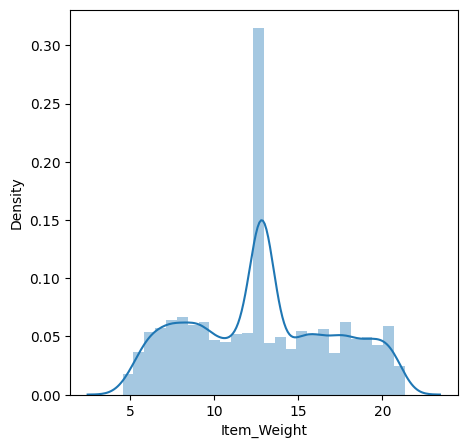

In [18]:
# Item_Weight distribution
plt.figure(figsize=(5,5))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

<ipython-input-21-42ccd2a9992d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Visibility'])


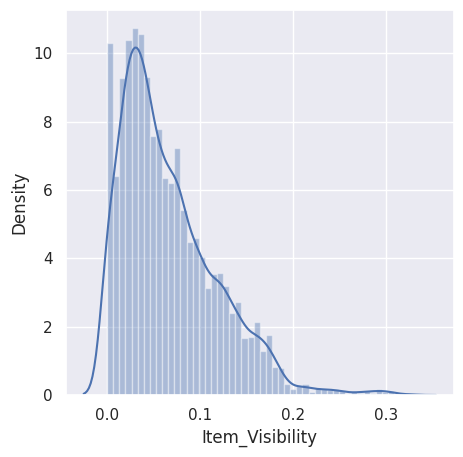

In [21]:
# Item Visibility distribution
plt.figure(figsize=(5,5))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

<ipython-input-22-a7ea88cdebd6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_MRP'])


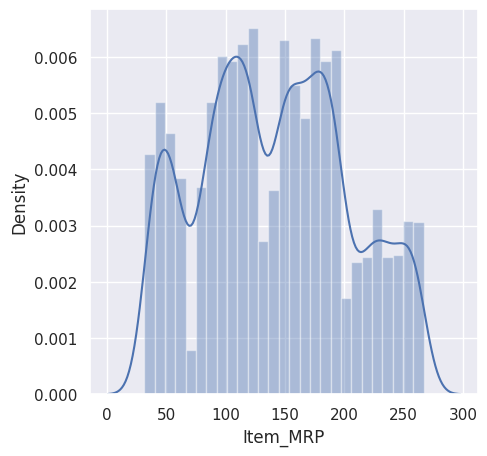

In [22]:
# Item MRP distribution
plt.figure(figsize=(5,5))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

<ipython-input-23-b5c72da69e0b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Outlet_Sales'])


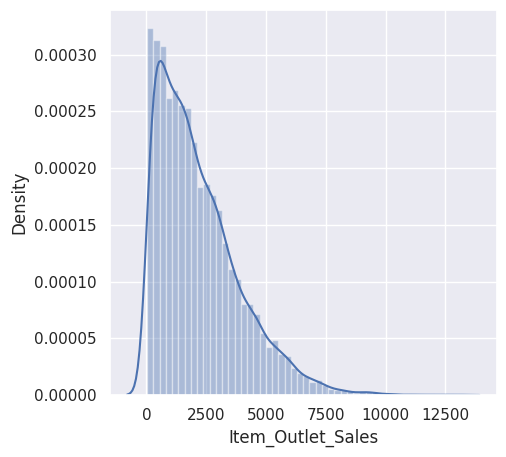

In [23]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(5,5))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

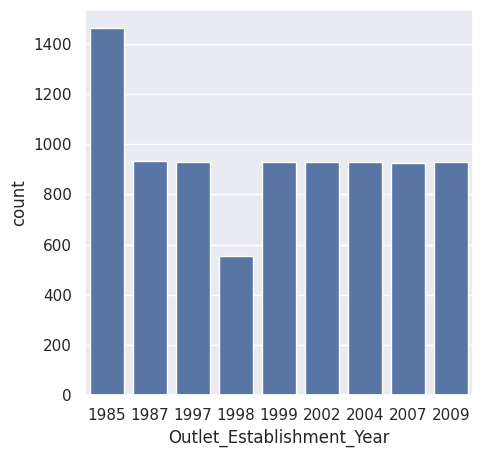

In [24]:
# Outlet_Establishment_Year column
plt.figure(figsize=(5,5))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

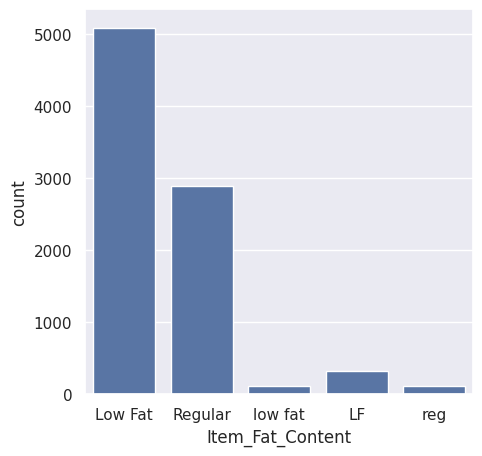

In [25]:
# Item_Fat_Content column
plt.figure(figsize=(5,5))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

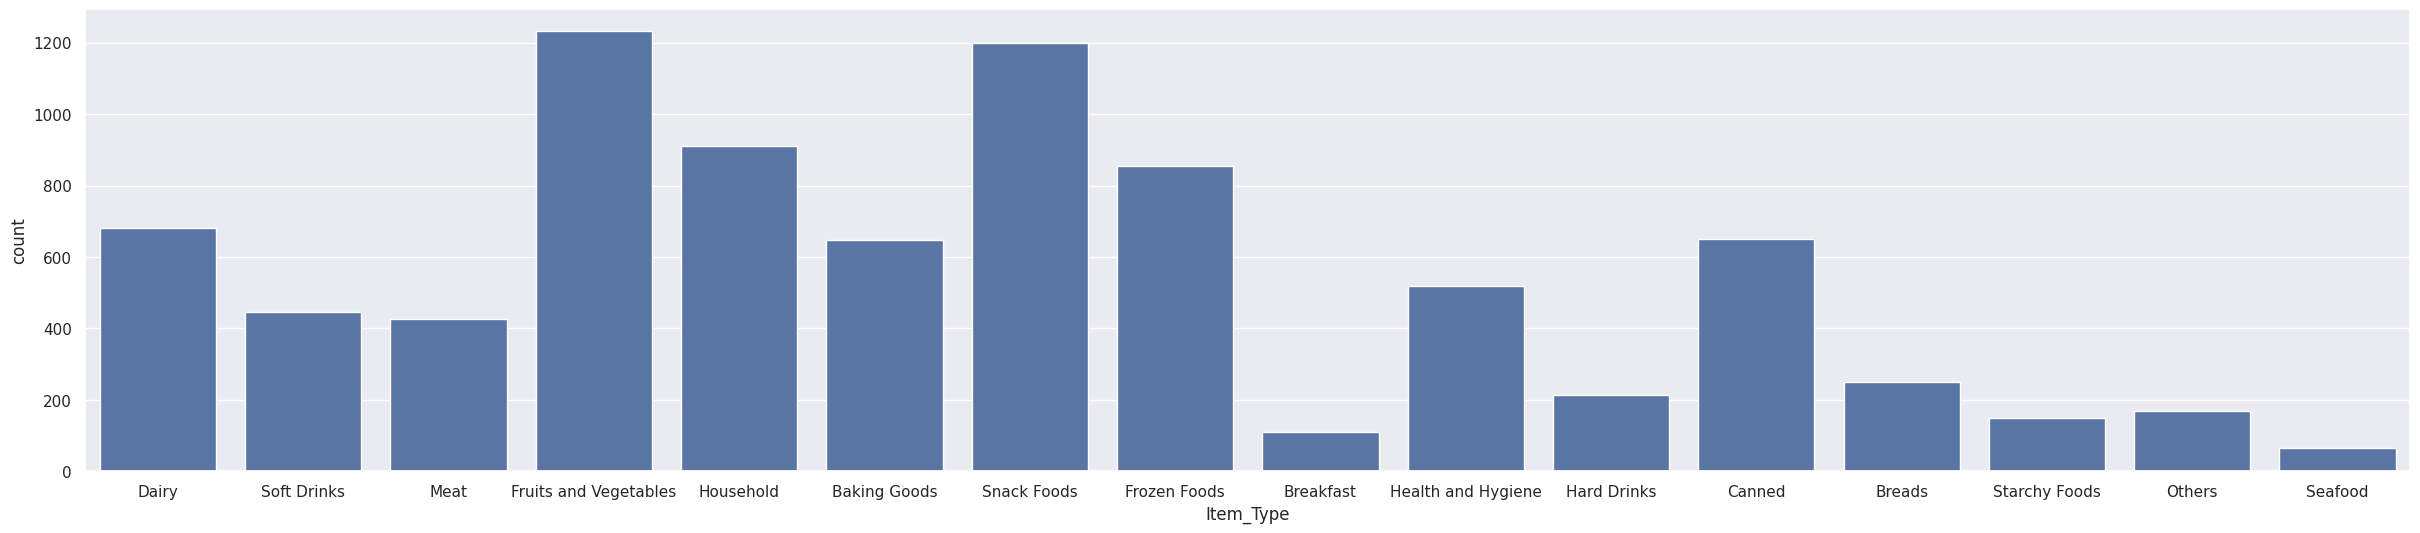

In [26]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

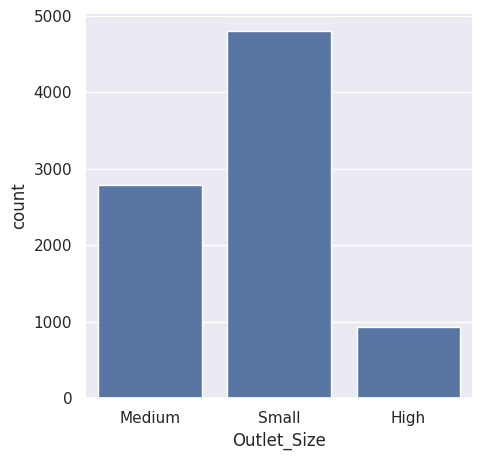

In [27]:
# Outlet_Size column
plt.figure(figsize=(5,5))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

# **Data Pre-Processing**

In [28]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [29]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [30]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [31]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


**Label Encoding**

In [32]:
encoder = LabelEncoder()

In [33]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [34]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


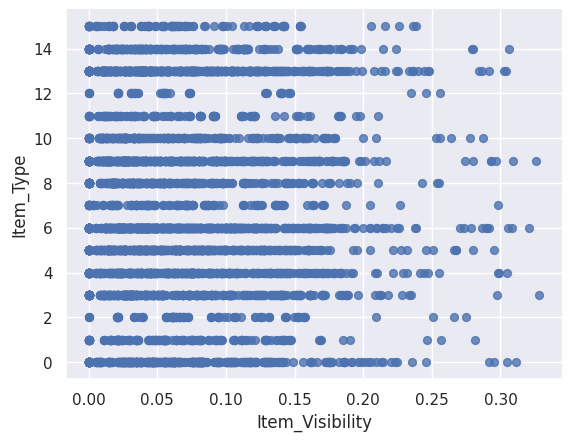

In [50]:
# @title Item_Visibility vs Item_Type

from matplotlib import pyplot as plt
big_mart_data.plot(kind='scatter', x='Item_Visibility', y='Item_Type', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

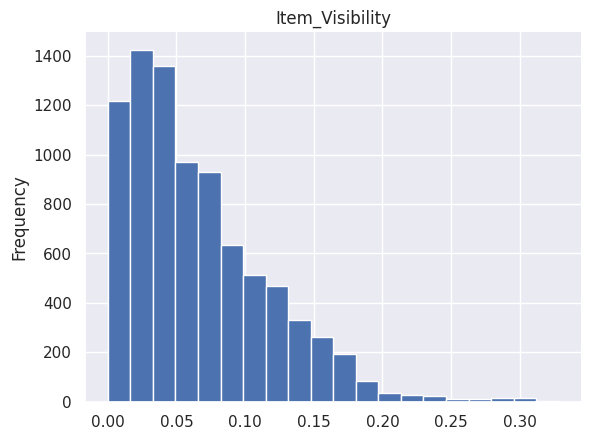

In [49]:
# @title Item_Visibility

from matplotlib import pyplot as plt
big_mart_data['Item_Visibility'].plot(kind='hist', bins=20, title='Item_Visibility')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [52]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=big_mart_data)

https://docs.google.com/spreadsheets/d/1MG9QYNOZll6p3Iw_EwbVrCIL2qq9w27rIrdhtLbzs8I#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [46]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=big_mart_data)

MessageError: Error: credential propagation was unsuccessful

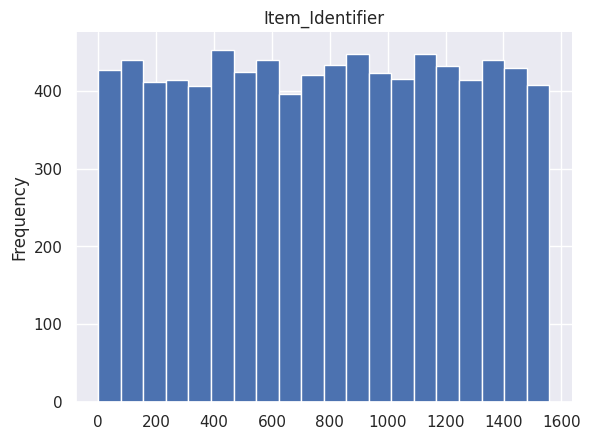

In [45]:
# @title Item_Identifier

from matplotlib import pyplot as plt
big_mart_data['Item_Identifier'].plot(kind='hist', bins=20, title='Item_Identifier')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Splitting features and Target**

In [35]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [36]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [37]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


**Splitting the data into Training data & Testing Data**

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [39]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


# **Model Training**

In [40]:
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [42]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print('R Squared value = ', r2_train)

R Squared value =  0.8762174618111388


In [43]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [44]:
# R squared Value
r2_test = metrics.r2_score(Y_test, test_data_prediction)
print('R Squared value = ', r2_test)

R Squared value =  0.5017253991620692
